# Random Forest Modeling

### Notebook Summary

In this notebook I will use GridSearchCV and RandomizedSearchCV to fit a wide range of Random Forest decision tree classifiers to my training data. Fitting decision trees instead of a simple multinomial Naive Bayes model, especially in the quantities generated by GridSearchCV and RandomizedSearchCV, will be far more computationally intensive. But it should produce a stronger predictive model.

In [1]:
import pandas as pd
import json, re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
import pickle

%matplotlib inline

## Vectorizing the Text

First I'll load in the feature (`X`) and target (`y`) data from the pre-processing notebook.

In [2]:
with open('../data/X_data.pkl', 'rb') as f:
    X = pickle.load(f)
with open('../data/y_data.pkl', 'rb') as f:
    y = pickle.load(f)

Next I'll split X and y into training and test sets, with a random_state of 42 for reproducibility. And although the sets of baseball and Dodger posts are pretty closely balanced to each other, I'll go ahead and stratify for good measure.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

I will load in the `TfidfVectorizer` that I instantiated in the pre-processing notebook.

In [4]:
with open('../assets/tfidf_vec.pkl', 'rb') as f:
    tfidf = pickle.load(f)

And now I will fit the vectorizer to my `X_train` data so it can learn the frequency rates of the key vocabulary used in those posts. It will then create a matrix of those frequencies, and I will create a dataframe from that matrix and store it in `train_df`.

In [6]:
train_raw = tfidf.fit_transform(X_train['text'])

train_df = pd.SparseDataFrame(train_raw, columns=tfidf.get_feature_names())
train_df.head()

With a `TfidfVectorizer`, the numeric values are typically floats rather than integers, and the vectorizer leaves many null values in the matrix. I will fill those null with 0's.

In [7]:
train_df.fillna(0, inplace=True)

Now I will use the fitted vectorizer to create a matrix of the frequency rates of the training data's most significant words as they appear in the testing data.

In [8]:
test_df = pd.SparseDataFrame(tfidf.transform(X_test['text']),
                             columns=tfidf.get_feature_names())
test_df.fillna(0, inplace=True)

Now I will use GridSearchCV to fit fifteen total Random Forest decision tree classifiers to the training data. The Random Forest model will fit to the data using all default parameters, except for `n_estimators`. It will draw the three different values for `n_estimators` from `params_default`, fit a decision tree with that number of estimators, and then perform 5-fold cross validation. So with three different parameter iterations and five-fold validation for each parameter value, fifteen trees will be fit.

In [43]:
params_default = {'n_estimators': [25, 50, 75]}

# gs_default = GridSearchCV(RandomForestClassifier(),
#                       param_grid=params_default, return_train_score=True, cv=5)
# gs_default.fit(train_df, y_train)
gs_default.score(train_df, y_train)

0.9921576650300055

That took a while to fit, so before I do anything else I need to pickle out this model for safekeeping.

In [11]:
# with open('../assets/gs_default.pkl', 'wb+') as f:
#     pickle.dump(gs_default, f)

Going back to the new model, the training score of .992 is incredibly high. As is typical of decision trees, this probably indicates that the model is overfit. I'll check the model's score on unseen data to verify.

In [41]:
gs_default.score(test_df, y_test)

0.8213153319014013

Yes, that's a dramatic drop in score from the training data to the testing data. In order to find a better-tuned model, I will run a RandomizedSearchCV with broader parameter values. But first I want to see what the best value for `n_estimators` was.

In [45]:
gs_default.best_params_

{'n_estimators': 75}

I will set that best value for `n_estimators` as static in the RandomizedSearchCV, which will randomly select `n_iter` number different parameter combinations from the `random_params` dictionary, and fit a decision tree classifier for each of those iterations, along with five-fold cross validation. This added dimension of randomization will hedge against the decision tree's tendency toward an overfit high-variance model.

In [46]:
random_params = {'min_samples_split': [2, 6, 8, 10, 12],
                 'min_samples_leaf': [1, 3, 5, 7, 9],
                 'max_features': ['auto', 'log2'],
                 'max_depth': [100, 150, 200, 250],
                 'boostrap': [True, False]
                }

# rf_randomized = RandomizedSearchCV(estimator = RandomForestClassifier(n_estimators=50),
#                                    param_distributions = random_params,
#                                    n_iter = 50, cv = 5, random_state=42, n_jobs = -1)

# rf_randomized.fit(train_df, y_train)
rf_randomized.score(train_df, y_train)

0.9513434260774686

Even moreso than the GridSearchCV, that RandomizedSearchCV fitting was a computational nightmare, so I'll pickle out the optimal model before going any further.

In [20]:
# with open('../assets/rf_randomized.pkl', 'wb+') as f:
#     pickle.dump(rf_randomized, f)

Now I want to see which combination of parameters produced the best model.

In [21]:
rf_randomized.best_params_

{'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 150,
 'bootstrap': False}

And now I'll see how the model stacks up against the unseen testing data.

In [22]:
rf_randomized.score(test_df, y_test)

0.816405850465378

This model is performing roughly as well on the testing data as the original GridSearched model, so there's still room for additional tuning to find the ideal combination of parameters. Or I might need to collect more data. On the positive side, the dropoff from the training score to the testing score, while still too large was not quite as steep with this model.

As I did with the Naive Bayes model, I now want to look at the probabilities that the model used to make its predictions and see if any inferences can be made from them.

In [29]:
pred_probas = [i[1] for i in rf_randomized.predict_proba(test_df)]
# pred_probas = rf_randomized.predict_proba(test_df)
# dodger_preds = pred_probas[:, 1]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_probas})

Next I'll plot the distribution of the predicted probabilities on a histogram.

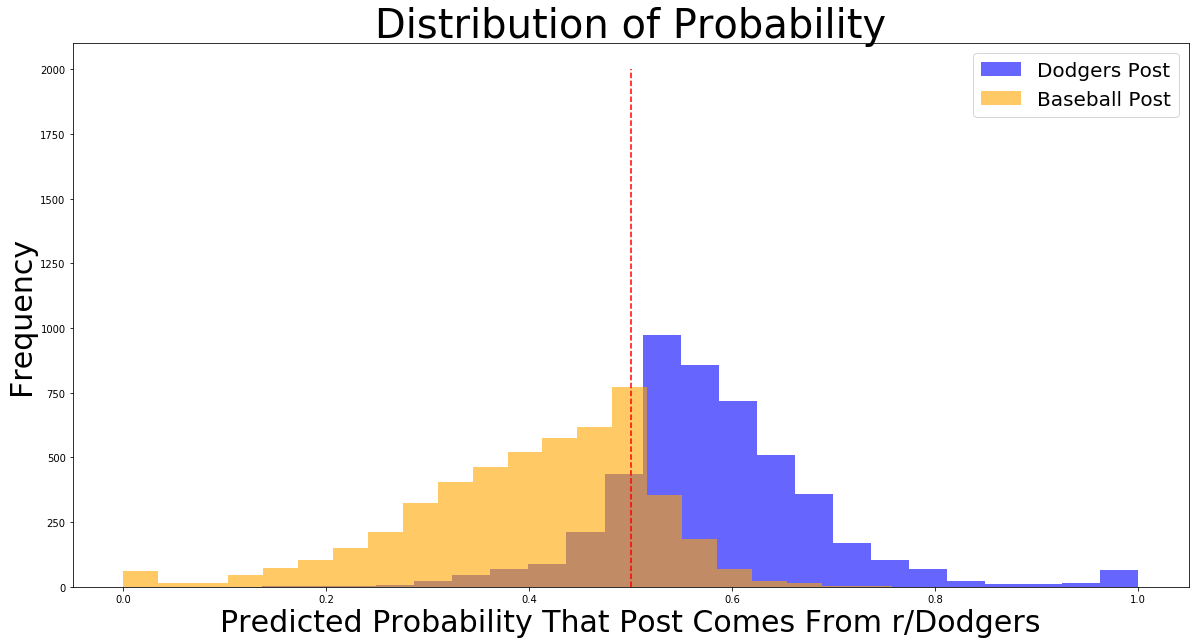

In [38]:
plt.figure(figsize = (20,10))

plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Dodgers Post')
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Baseball Post')

plt.vlines(x=0.5,
           ymin = 0,
           ymax = 2000,
           color='r',
           linestyle = '--')

plt.title('Distribution of Probability', fontsize=40)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Predicted Probability That Post Comes From r/Dodgers', fontsize=30)

plt.legend(fontsize=20);

plt.savefig('../viz_exports/RF_ProbDist.png');

This is an encouraging plot. This model doesn't have many high-certainty predictions for either class, but there is relatively minimal overlap between the two classes. And the overlap that does exist is normally distributed right at the prediction threshold. With additional tuning it should be possible to see additional separation between the two classes and a more accurate prediction model.

As I did with the Naive Bayes model, I now want to see if I can gain any insights from which words are carrying substantial weight in the prediction model. I will extract the `feature_importances_` from the model's `best_estimator_` and store them in a new dataframe, corresponding to their respective features.

In [24]:
feat_importance_rf_randomized = pd.DataFrame(rf_randomized.best_estimator_.feature_importances_,
                               train_df.columns,
                               columns=['importance'])

Now that I have the feature importances, I will plot the importances below:

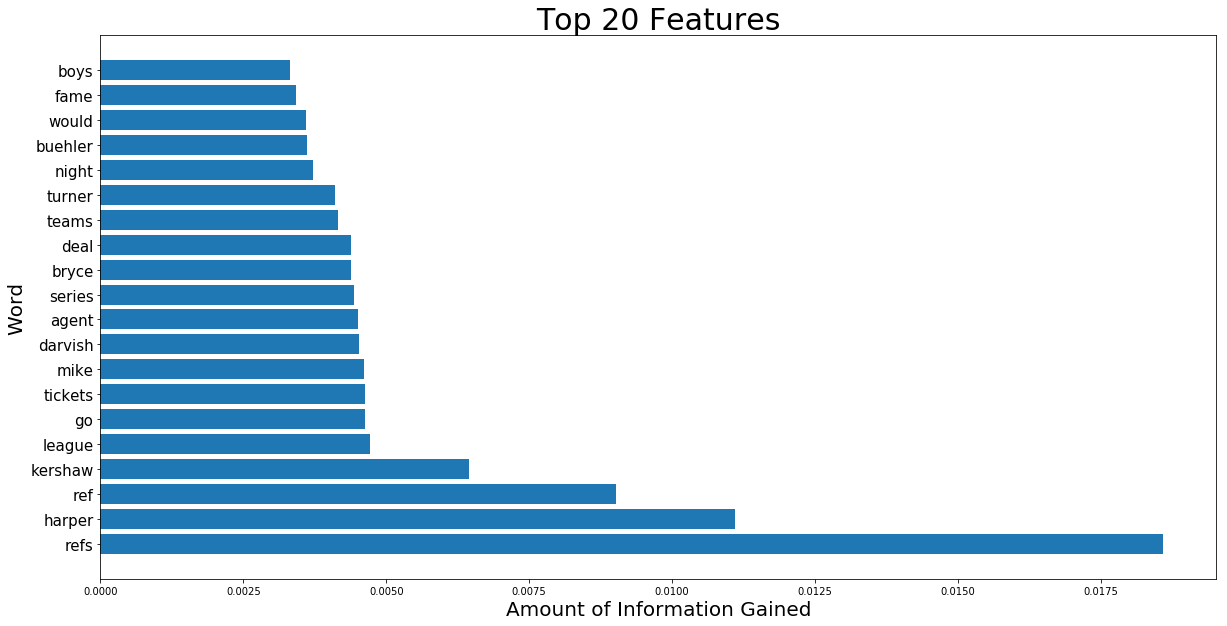

In [37]:
plt.figure(figsize=(20,10))
temp = feat_importance_rf_randomized.sort_values('importance', ascending=False).head(20)
plt.barh(temp.index, temp['importance'])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of Information Gained', fontsize=20)
plt.ylabel('Word', fontsize=20)
plt.yticks(fontsize=15)
plt.savefig('../viz_exports/RF_Top20Features.png');

I notice that even with the Dodgers' team name dummied out with every other team name in the league, the dummy word is standing out as a powerful predictor of a post from r/Dodgers. Perhaps Dodgers fans are invoking their team name at a much higher rate than other fanbases?

The other thing that stands out to me are the player names. It seems that the Dodgers fans enjoy discussing their players at a frequent enough rate for the player names to be a strong predictor of a Dodgers post. Even for someone as big as Clayton Kershaw, whose name would be in regular conversation among other fanbases, the Dodgers fans are discussing him enough for it to be a tell.

This concludes the coding portion of the report. Please refer to the provided `README.md` file for additional interpretation of the findngs.